In [1]:
import argparse
import numpy as np
from dataset import *
from models import * 
from utils import *
from generation import *
import time 

from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
DIR_PATH = "dataset/poems.csv"
SOV_TOKEN = "<SOV>" # start of verse
EOV_TOKEN = "<EOV>" # end of verse
encoder_ckpt = "saved_models/encoder_13.pt"
decoder_ckpt = "saved_models/decoder_13.pt"

parser = argparse.ArgumentParser()
parser.add_argument('--max_epochs', type=int, default=30)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--sequence_length', type=int, default=10)
args, unknown = parser.parse_known_args()

# Define the dataset and dataloader
dataset = SpanishPoemsDataset(DIR_PATH, SOV_TOKEN, EOV_TOKEN, args)
dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

print(dataset.__getitem__(3))
print('Vocab:', len(dataset.unique_words))

(tensor([2449, 1375,    1,    0,    6,   15, 2450, 2451,    5,   66]), tensor([1375,    1,    0,    6,   15, 2450, 2451,    5,   66, 2452]))
Vocab: 7506


# TRAINING

In [5]:
# Set hyperparameters

input_size = len(dataset.unique_words) # size of the vocabulary for the input sequence
output_size = len(dataset.unique_words) # size of the vocabulary for the target sequence
hidden_size = 128
num_layers = 1
batch_size = args.batch_size
sequence_length = args.sequence_length
num_epochs = args.max_epochs
learning_rate = 0.003

# Instantiate the encoder and decoder
encoder = LSTMEncoder(input_size, hidden_size, num_layers)
decoder = GRUDecoder(hidden_size, output_size, num_layers)
#encoder = Encoder(input_size, hidden_size, num_layers).to(device)
#decoder = Decoder(hidden_size, output_size, num_layers).to(device)

# Define the loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

In [6]:
start_time = time.time()
loss_history = []
encoder.train()
decoder.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch_inputs, batch_targets in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        #batch_inputs = batch_inputs
        #batch_targets = batch_targets

        # Initialize the hidden state and cell state of the encoder
        hidden, cell_state = encoder.init_hidden(sequence_length)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass - Encoder
        encoder_outputs, (hidden, cell_state) = encoder(batch_inputs, (hidden, cell_state))  # Updated for LSTM

        # Initialize the hidden state of the decoder with the final encoder hidden state
        decoder_hidden = hidden[:, 1:sequence_length, :].contiguous()

        # Prepare the input and target sequences for the decoder
        decoder_inputs = batch_targets[:, :-1]
        decoder_targets = batch_targets[:, 1:]

        # Forward pass - Decoder
        decoder_outputs, _ = decoder(decoder_inputs, decoder_hidden)

        # Calculate the loss
        loss = criterion(decoder_outputs.reshape(-1, output_size), decoder_targets.reshape(-1))

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Save the model after each epoch
    torch.save(encoder.state_dict(), encoder_ckpt)
    torch.save(decoder.state_dict(), decoder_ckpt)

    # Print average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time/3600) 


Epoch 1/30: 100%|██████████| 323/323 [01:36<00:00,  3.36it/s]


Epoch 1/30, Loss: 5.6941


Epoch 2/30: 100%|██████████| 323/323 [01:34<00:00,  3.41it/s]


Epoch 2/30, Loss: 4.6815


Epoch 3/30: 100%|██████████| 323/323 [01:27<00:00,  3.68it/s]


Epoch 3/30, Loss: 4.1065


Epoch 4/30: 100%|██████████| 323/323 [01:28<00:00,  3.66it/s]


Epoch 4/30, Loss: 3.5865


Epoch 5/30: 100%|██████████| 323/323 [01:27<00:00,  3.67it/s]


Epoch 5/30, Loss: 3.1140


Epoch 6/30: 100%|██████████| 323/323 [01:34<00:00,  3.42it/s]


Epoch 6/30, Loss: 2.6936


Epoch 7/30: 100%|██████████| 323/323 [01:28<00:00,  3.67it/s]


Epoch 7/30, Loss: 2.3336


Epoch 8/30: 100%|██████████| 323/323 [01:34<00:00,  3.42it/s]


Epoch 8/30, Loss: 2.0322


Epoch 9/30: 100%|██████████| 323/323 [01:28<00:00,  3.66it/s]


Epoch 9/30, Loss: 1.7771


Epoch 10/30: 100%|██████████| 323/323 [01:29<00:00,  3.63it/s]


Epoch 10/30, Loss: 1.5623


Epoch 11/30: 100%|██████████| 323/323 [01:28<00:00,  3.66it/s]


Epoch 11/30, Loss: 1.3804


Epoch 12/30: 100%|██████████| 323/323 [01:34<00:00,  3.40it/s]


Epoch 12/30, Loss: 1.2250


Epoch 13/30: 100%|██████████| 323/323 [01:28<00:00,  3.63it/s]


Epoch 13/30, Loss: 1.1054


Epoch 14/30: 100%|██████████| 323/323 [01:34<00:00,  3.42it/s]


Epoch 14/30, Loss: 0.9908


Epoch 15/30: 100%|██████████| 323/323 [01:29<00:00,  3.60it/s]


Epoch 15/30, Loss: 0.8863


Epoch 16/30: 100%|██████████| 323/323 [01:31<00:00,  3.54it/s]


Epoch 16/30, Loss: 0.7873


Epoch 17/30: 100%|██████████| 323/323 [01:24<00:00,  3.81it/s]


Epoch 17/30, Loss: 0.6972


Epoch 18/30: 100%|██████████| 323/323 [01:24<00:00,  3.81it/s]


Epoch 18/30, Loss: 0.6021


Epoch 19/30: 100%|██████████| 323/323 [01:24<00:00,  3.82it/s]


Epoch 19/30, Loss: 0.5344


Epoch 20/30: 100%|██████████| 323/323 [01:28<00:00,  3.66it/s]


Epoch 20/30, Loss: 0.4836


Epoch 21/30: 100%|██████████| 323/323 [01:23<00:00,  3.86it/s]


Epoch 21/30, Loss: 0.4371


Epoch 22/30: 100%|██████████| 323/323 [01:24<00:00,  3.83it/s]


Epoch 22/30, Loss: 0.3976


Epoch 23/30: 100%|██████████| 323/323 [01:24<00:00,  3.80it/s]


Epoch 23/30, Loss: 0.3620


Epoch 24/30: 100%|██████████| 323/323 [01:24<00:00,  3.83it/s]


Epoch 24/30, Loss: 0.3305


Epoch 25/30: 100%|██████████| 323/323 [01:23<00:00,  3.85it/s]


Epoch 25/30, Loss: 0.2938


Epoch 26/30: 100%|██████████| 323/323 [01:29<00:00,  3.60it/s]


Epoch 26/30, Loss: 0.2718


Epoch 27/30: 100%|██████████| 323/323 [01:24<00:00,  3.81it/s]


Epoch 27/30, Loss: 0.2523


Epoch 28/30: 100%|██████████| 323/323 [01:24<00:00,  3.82it/s]


Epoch 28/30, Loss: 0.2241


Epoch 29/30: 100%|██████████| 323/323 [01:24<00:00,  3.81it/s]


Epoch 29/30, Loss: 0.2029


Epoch 30/30: 100%|██████████| 323/323 [01:30<00:00,  3.58it/s]

Epoch 30/30, Loss: 0.2061
Elapsed time:  0.7377101129293442


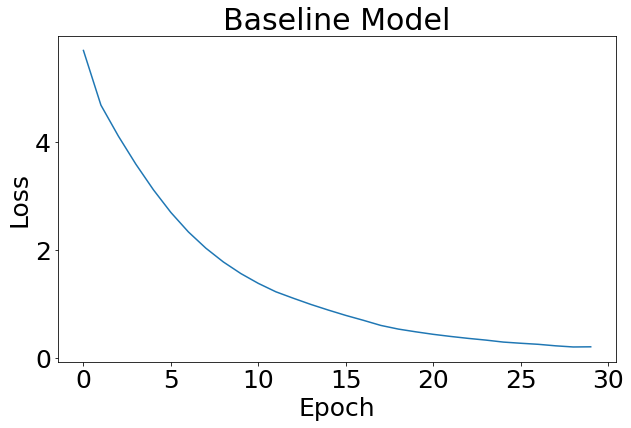

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 25
plt.figure(figsize=(10,6))
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Baseline Model")
#plt.savefig("baseline.jpg", bbox_inches='tight')
plt.show()

# GENERATE POEM 

In [13]:
poem, perplexity = generate_poem_GRU(
    encoder, decoder, dataset, 
    0, 1, max_length=30, temperature=0.8, top_k=10, 
    encoder_type='LSTM', 
    encoder_ckpt=encoder_ckpt, 
    decoder_ckpt=decoder_ckpt
)

print('')
print(poem)
print('Perplexity: ', perplexity)


lo que quedaba
a la patagonia en que es un río
y al que un día
te diría quererte más allá
de
Perplexity:  13.503673090285206
